In [1]:
import numpy.random as rand
import matplotlib.pyplot as plot
import numpy as numpy
from scipy.optimize import linprog
from numpy import linalg
%matplotlib inline

Покажем, что если алгоритм сходится, то он сходится к решению задачи ЛП при $\mu\to0$. Действительно, По теореме о комплиментарной фиктивности условия $X^*Y_s^*1 = 0$ и $Y^*X^*_s1 = 0$ являются критерием того, что допустимая точка $x^*, x_s^*, y^*, y_s^*$ - решение задачи. Но при $\mu\to0$, так же и $X^kY_s^k1\to0$ и $Y^kX_s^k1\to0$, а следовательно $(x^k, x_s^k, y^k, y_s^k)\to(x^*, x_s^*, y^*, y_s^*)$

Для решения уравнения $F(x, x_s, y, y_s)=0$ воспользуемся методом Ньютона. Для этого требуется посчитать матрицу якоби $F$

$$
J=\begin{pmatrix}
A&E&0&0\\
0&0&A^T&-E\\
Y_s&0&0&X\\
0&Y&X_s&0
\end{pmatrix}
$$

In [2]:
def jacobian(A, x, x_s, y, y_s):
    n = len(x)
    m = len(y)
    columns = [
        numpy.concatenate([A, numpy.zeros([n, n]), numpy.diag(y_s), numpy.zeros([m, n])], 0),
        numpy.concatenate([numpy.eye(m), numpy.zeros([2 * n, m]), numpy.diag(y)], 0),
        numpy.concatenate([numpy.zeros([m, m]), A.T, numpy.zeros([n, m]), numpy.diag(x_s)], 0),
        numpy.concatenate([numpy.zeros([m, n]), -numpy.eye(n), numpy.diag(x), numpy.zeros([m, n])], 0)
    ]
    return numpy.concatenate(columns, 1)

In [3]:
# Вспомогательная фукция
def has_negative(array):
    for element in array:
        if element < 0:
            return True
    return False

Для того, чтобы не выходить за пределы положительных переменных в итерационном процессе, каждый раз, когда получается так, что мы вышли, возвращаемся обратно и уменьшаем шаг в 2 раза, пока не останемся в области положительных значений.

In [4]:
epsilon = 0.001
k_max = 10000

def get_F(A, b, c, x, x_s, y, y_s, mu):
    n = len(x)
    m = len(y)
    parts = [
        x * A.T + x_s - b,
        y * A - y_s - c,
        numpy.matrix(numpy.ones([1, n])) * numpy.diag(x) * numpy.diag(y_s) - mu * numpy.ones([1, n]),
        numpy.matrix(numpy.ones([1, m])) * numpy.diag(y) * numpy.diag(x_s) - mu * numpy.ones([1, m])
    ]
    return numpy.array(numpy.concatenate(parts, 1))[0]

def solve(A, b, c, mu):
    step = 1

    m = A.shape[0]
    n = A.shape[1]
    # X = (x, x_s, y, y_s)
    X = numpy.array([1 for i in range(2 * n + 2 * m)])

    while True:
        x = numpy.array(X[:n])
        x_s = numpy.array(X[n : n + m])
        y = numpy.array(X[n + m : n + 2 * m])
        y_s = numpy.array(X[n + 2 * m:])

        X_old = X.copy()
        X = numpy.array(X - step * get_F(A, b, c, x, x_s, y, y_s, mu) * jacobian(A, x, x_s, y, y_s).I.T)[0]

        while has_negative(X):
            step /= 2
            X = X_old.copy()
            X = numpy.array(X - step * get_F(A, b, c, x, x_s, y, y_s, mu) * jacobian(A, x, x_s, y, y_s).I.T)[0]

        if linalg.norm(X - X_old, 2) < epsilon:
            break
    return X

def find_x(A, b, c):
    mu = 1
    try:
        answer = solve(A, b, c, mu)
    except:
        print("Can't solve en equation. Еhe problem is non limited.")
        return

    result_x = [answer[0]]
    result_y = [answer[1]]
    for k in range(k_max):
        previous = answer.copy()
        mu /= 10
        try:
            answer = solve(A, b, c, mu)
        except:
            print("Can't solve en equation. Еhe problem is non limited.")
            return
        result_x.append(answer[0])
        result_y.append(answer[1])

        if linalg.norm(previous - answer, 2) < epsilon:
            break
    return result_x, result_y

Для тестирования взята задача ЛП со следующими параметрами:

$$
A=\begin{pmatrix}
1&0\\
-1&0\\
0&1\\
0&-1\\
1&1
\end{pmatrix}
$$

$$
b=\begin{pmatrix}
10\\
5\\
5\\
10\\
18
\end{pmatrix}
$$

$$
b=\begin{pmatrix}
2\\
1
\end{pmatrix}
$$

In [5]:
A = numpy.matrix([[1, 0], [-1, 0], [0, 1], [0, -1], [1, 1]])
b = numpy.array([10, 5, 10, 5, 18])
c = numpy.array([2, 1])

In [6]:
x, y = find_x(A, b, c)

(4, 11)

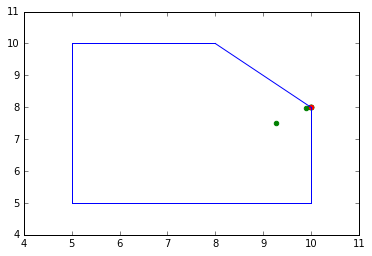

In [7]:
plot.plot([5, 10], [5, 5], color="blue")
plot.plot([5, 5], [5, 10], color="blue")
plot.plot([5, 8], [10, 10], color="blue")
plot.plot([10, 10], [5, 8], color="blue")
plot.plot([8, 10], [10, 8], color="blue")
plot.scatter(x, y, color="green")
plot.scatter([10], [8], color="red")
axis = plot.gca()
axis.set_ylim(4, 11)
axis.set_xlim(4, 11)

На рисунке допустимая область обведена в синюю рамку. Оптимальная точка омечена красным цветом, а точки, по которым алгоритм приближался к решению - зеленым. Алгорим сработал успешно и сошелся к правильному ответу.

Условием, по которому можно детектировать неограниченность задачи ЛП является остуствие решения у уравнения $F(x, x_s, y, y_s)=0$

Рассмотрим неограниченую задачу и убедимся, что таким образом можно отловить неограниченность задачи. Допустимая область изображена на рисунке.

$$
A=\begin{pmatrix}
-1&0\\
0&-1
\end{pmatrix}
$$

$$
b=\begin{pmatrix}
10\\
10
\end{pmatrix}
$$

$$
b=\begin{pmatrix}
2\\
1
\end{pmatrix}
$$

In [8]:
bad_A = numpy.matrix([[-1, 0], [0, -1]])
bad_b = numpy.array([10, 10])
bad_c = numpy.array([2, 1])

(4, 11)

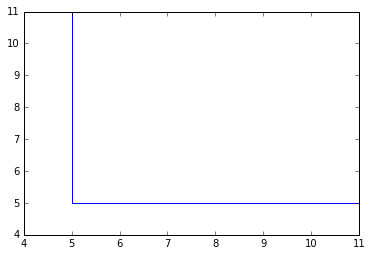

In [9]:
plot.plot([5, 11], [5, 5], color="blue")
plot.plot([5, 5], [5, 11], color="blue")
axis = plot.gca()
axis.set_ylim(4, 11)
axis.set_xlim(4, 11)

In [10]:
result = find_x(bad_A, bad_b, bad_c)

Can't solve en equation. Еhe problem is non limited.


Алгоритм отловил неограниченность.